#**Setting up colab to download dataset straight from kaggle**

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download elikplim/ecoli-data-set

  0% 0.00/4.34k [00:00<?, ?B/s]
100% 4.34k/4.34k [00:00<00:00, 10.2MB/s]


In [ ]:
! unzip ecoli-data-set.zip

Archive:  ecoli-data-set.zip
  inflating: ecoli.csv               


#**Setting, exploring the data**




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

In [ ]:
columns = ['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'site']
data = pd.read_csv('/content/ecoli.csv', sep = "\s+", header = None, names = columns)
data.head(10)

,sequence_name,mcg,gvh,lip,chg,aac,alm1,alm2,site
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,ALKH_ECOLI,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,AMPD_ECOLI,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp
7,AMY2_ECOLI,0.21,0.34,0.48,0.5,0.51,0.28,0.39,cp
8,APT_ECOLI,0.20,0.44,0.48,0.5,0.46,0.51,0.57,cp
9,ARAC_ECOLI,0.42,0.40,0.48,0.5,0.56,0.18,0.30,cp


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sequence_name  336 non-null    object 
 1   mcg            336 non-null    float64
 2   gvh            336 non-null    float64
 3   lip            336 non-null    float64
 4   chg            336 non-null    float64
 5   aac            336 non-null    float64
 6   alm1           336 non-null    float64
 7   alm2           336 non-null    float64
 8   site           336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [ ]:
data.describe()

,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


based on mean of all columns there is no need to rescale values

In [ ]:
data.isna().sum()

sequence_name    0
mcg              0
gvh              0
lip              0
chg              0
aac              0
alm1             0
alm2             0
site             0
dtype: int64

<Axes: >

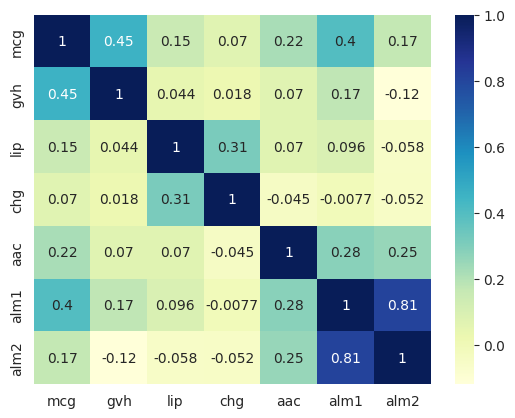

In [ ]:
sns.heatmap(data.corr(), annot = True, cmap='YlGnBu')


biggest correlation between:
1. gvh - mcg,
2. mcg-alm1,
3. lip-chg
4. alm1 - alm2

In [ ]:
#number of unqiue values in target column
n_classes = len(np.unique(data['site'], return_counts = True)[0])
n_classes

8

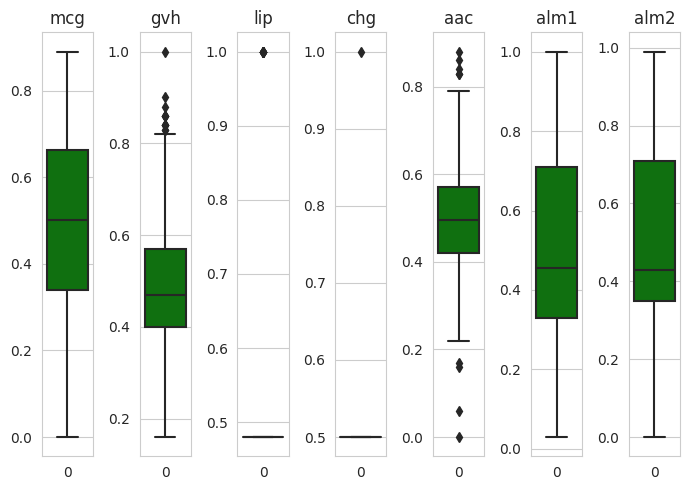

In [ ]:
l = data.columns.values[1:-1]
number_of_columns=len(l)
number_of_rows = 1
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows, number_of_columns, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[l[i]],color='green',orient='v')
    plt.title(l[i])
    plt.tight_layout()


mcg, alm1, alm2 - no outliers

lip, chg - small std

In [ ]:
def find_outliers(data):
  Q1 = data.quantile(0.25, numeric_only = True)
  Q3 = data.quantile(0.75, numeric_only = True)
  IQR = Q3 - Q1
  outlier_condition = ((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR))
  return outlier_condition.sum(axis = 0)[:-2] #dont count object-type columns

In [ ]:
find_outliers(data)

aac      9
alm1     0
alm2     0
chg      1
gvh     13
lip     10
mcg      0
dtype: int64

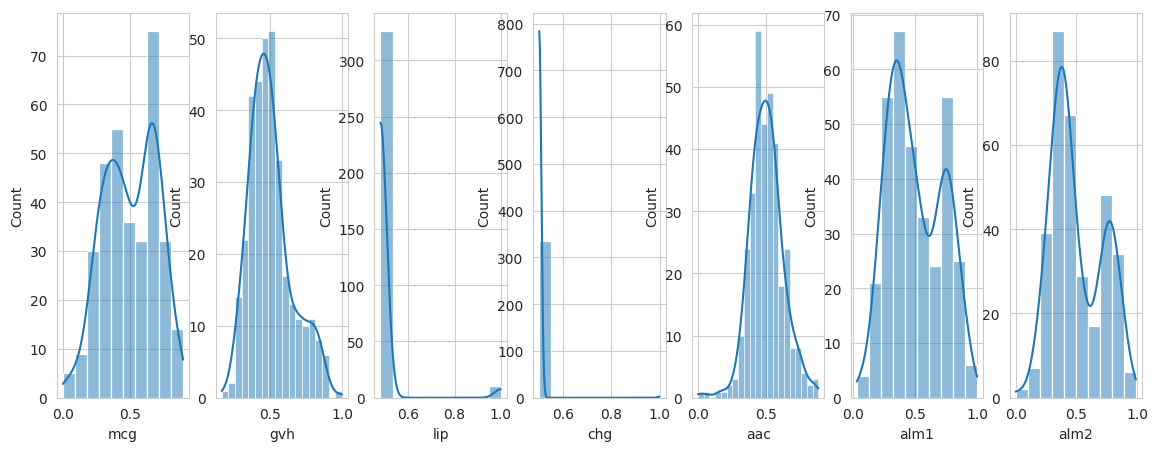

In [ ]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows,number_of_columns,i+1)
    sns.histplot(data[l[i]], kde = True)

#**Shapes of distribution:**

mcg, alm1, alm2 - asymetric bimodal

gvh - ps. skewed gaussian

aac - neg. skewed gaussian

#**Splitting data on training / test set**


In [ ]:
#dropping sequence_name column
data.drop('sequence_name', inplace = True, axis = 1)

#splitting data on train / test set
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

Y = Y.to_numpy()
print("Before encoding: ",Y)
#encoding Y labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print("After encoding: ",Y)
Y = Y.reshape(-1,1)
#X = X.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)

Before encoding:  ['cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp' 'cp'
 'cp' 'cp' 'cp' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im'
 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im'
 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im'
 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im' 'im

# **Creating multiclass classifier - Neural Network**

In [ ]:
N_samples, D_features = x_train.shape

In [ ]:
epochs = 50

In [ ]:
i = Input(shape = (D_features))
x = Dense(64, activation = 'relu')(i)
x = Dense(128, activation = 'relu')(x)
o = Dense(n_classes, activation = 'softmax')(x)

In [ ]:
model = Model(i, o)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
r = model.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/50
9/9 [==============================] - 2s 74ms/step - loss: 2.0176 - accuracy: 0.2799 - val_loss: 1.9029 - val_accuracy: 0.5147
Epoch 2/50
9/9 [==============================] - 0s 20ms/step - loss: 1.8612 - accuracy: 0.4590 - val_loss: 1.7415 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 0s 23ms/step - loss: 1.7230 - accuracy: 0.4776 - val_loss: 1.5807 - val_accuracy: 0.5588
Epoch 4/50
9/9 [==============================] - 0s 20ms/step - loss: 1.5898 - accuracy: 0.5485 - val_loss: 1.4380 - val_accuracy: 0.6618
Epoch 5/50
9/9 [==============================] - 0s 19ms/step - loss: 1.4861 - accuracy: 0.5821 - val_loss: 1.3203 - val_accuracy: 0.6618
Epoch 6/50
9/9 [==============================] - 0s 27ms/step - loss: 1.4100 - accuracy: 0.5746 - val_loss: 1.2122 - val_accuracy: 0.6618
Epoch 7/50
9/9 [==============================] - 0s 26ms/step - loss: 1.3355 - accuracy: 0.5821 - val_loss: 1.1260 - val_accuracy: 0.6765
Epoch 8/50
9/9 [===========

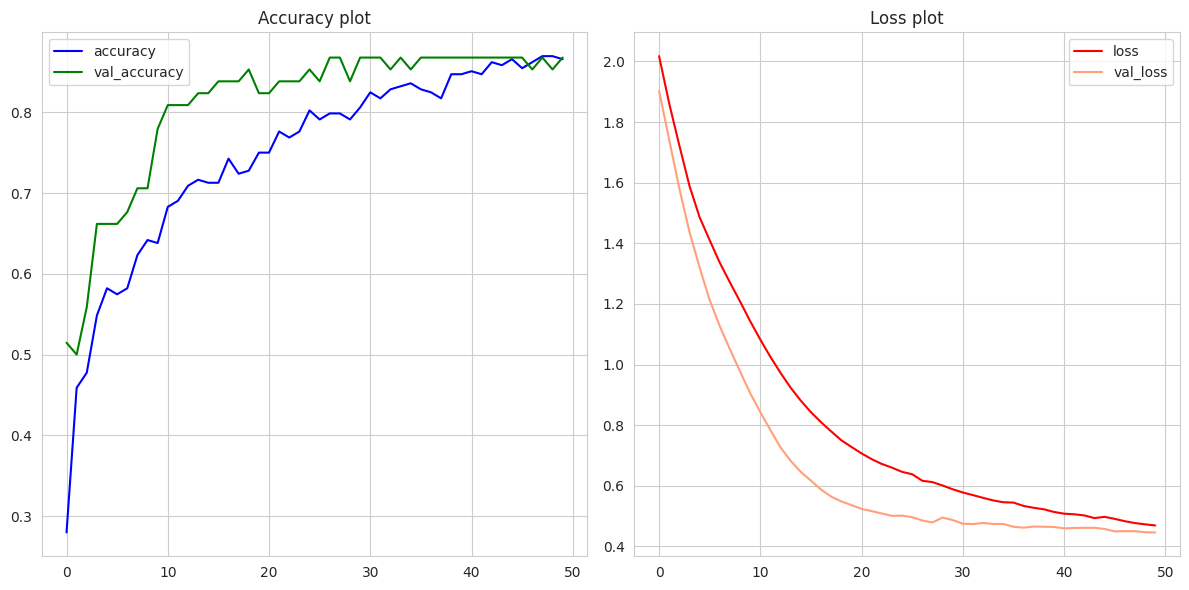

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
ax[0].plot(range(epochs), r.history['accuracy'], color='blue', label = 'accuracy')
ax[0].plot(range(epochs), r.history['val_accuracy'], color='green', label = 'val_accuracy')
ax[0].set_title('Accuracy plot')
ax[0].legend()
ax[1].plot(range(epochs), r.history['loss'], color='red', label = 'loss')
ax[1].plot(range(epochs), r.history['val_loss'], color = 'lightsalmon', label = 'val_loss')
ax[1].set_title('Loss plot')
ax[1].legend()
fig.tight_layout()
fig.show()

#**Searching for best perfoming hyperparameters of model using keras tuner**

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape = (D_features, )))

  hp_layers = hp.Int('num_layers', 1, 4)
  for i in range(hp_layers):
    model.add(Dense(units = hp.Int('units_' + str(i), min_value = 16, max_value = 256, step = 16),
     activation = 'relu'))

  model.add(Dense(n_classes, activation = 'softmax'))

  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = 'val_accuracy',
    max_epochs = 100,
    factor = 4
)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#creating EarlyStopping algorithm to decrease time of search

callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.5,
    patience = 3
)


In [ ]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks = [callback])

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best hyperparameters found:\nNumber of Dense layers: {best_hps.get('num_layers')}\nNumber of units in layer, in order: {best_hps.get('units_0')}, {best_hps.get('units_1')}, {best_hps.get('units_2')}, {best_hps.get('units_3')}")


Best hyperparameters found:
Number of Dense layers: 3
Number of units in layer, in order: 144, 80, 240, 128


In [ ]:
epochs = 40
best_model = tuner.get_best_models(num_models = 1)[0]
r = best_model.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/40
9/9 [==============================] - 1s 46ms/step - loss: 0.8324 - accuracy: 0.7351 - val_loss: 0.5953 - val_accuracy: 0.8529
Epoch 2/40
9/9 [==============================] - 0s 17ms/step - loss: 0.7715 - accuracy: 0.7463 - val_loss: 0.5673 - val_accuracy: 0.8529
Epoch 3/40
9/9 [==============================] - 0s 14ms/step - loss: 0.7246 - accuracy: 0.7537 - val_loss: 0.5512 - val_accuracy: 0.8382
Epoch 4/40
9/9 [==============================] - 0s 12ms/step - loss: 0.6873 - accuracy: 0.7724 - val_loss: 0.5217 - val_accuracy: 0.8382
Epoch 5/40
9/9 [==============================] - 0s 10ms/step - loss: 0.6623 - accuracy: 0.7649 - val_loss: 0.5124 - val_accuracy: 0.8382
Epoch 6/40
9/9 [==============================] - 0s 8ms/step - loss: 0.6389 - accuracy: 0.7836 - val_loss: 0.5241 - val_accuracy: 0.8382
Epoch 7/40
9/9 [==============================] - 0s 9ms/step - loss: 0.6326 - accuracy: 0.7724 - val_loss: 0.5131 - val_accuracy: 0.8382
Epoch 8/40
9/9 [=============

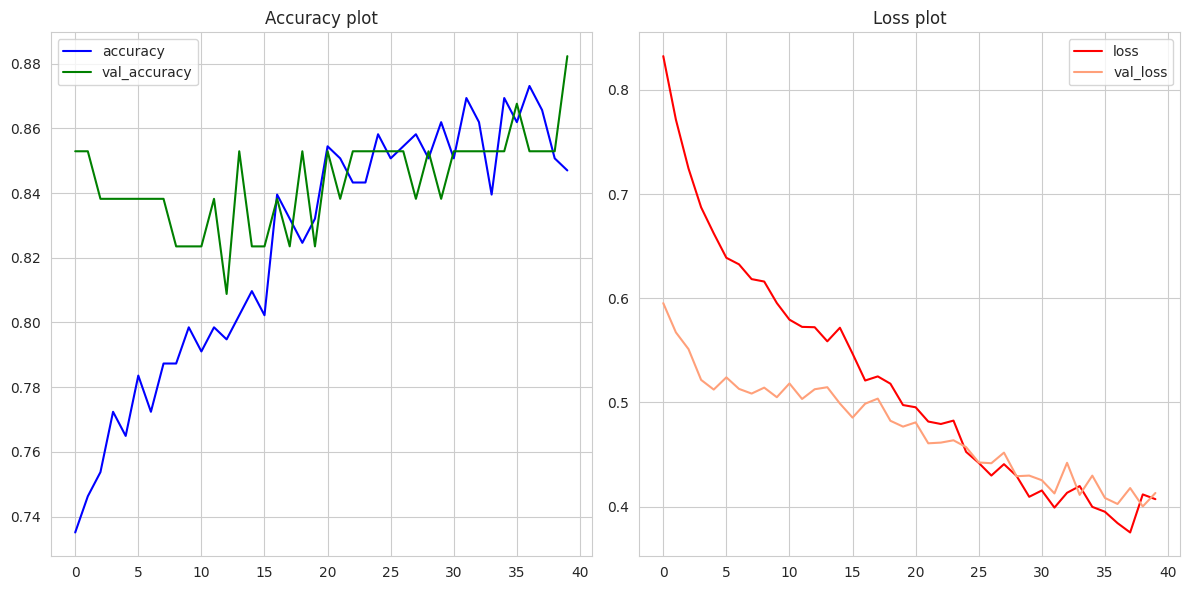

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
ax[0].plot(range(epochs), r.history['accuracy'], color='blue', label = 'accuracy')
ax[0].plot(range(epochs), r.history['val_accuracy'], color='green', label = 'val_accuracy')
ax[0].set_title('Accuracy plot')
ax[0].legend()
ax[1].plot(range(epochs), r.history['loss'], color='red', label = 'loss')
ax[1].plot(range(epochs), r.history['val_loss'], color = 'lightsalmon', label = 'val_loss')
ax[1].set_title('Loss plot')
ax[1].legend()
fig.tight_layout()
fig.show()

Tuned model has a high variance plots, loss functions are going down but not as smooth as before tuning. Better accuracy was earned / around 88% in best epoch



#**Changing dataset characteristics to see if it increases the predictions**

**Deleting most correlating columns** - alm1 and alm2 with strong corelation equal to 0.81. A situation called **multicolinearity**

In [ ]:
X_2 = X.drop(['alm1', 'alm2'], axis = 1)
X_2

,mcg,gvh,lip,chg,aac
0,0.49,0.29,0.48,0.5,0.56
1,0.07,0.40,0.48,0.5,0.54
2,0.56,0.40,0.48,0.5,0.49
3,0.59,0.49,0.48,0.5,0.52
4,0.23,0.32,0.48,0.5,0.55
...,...,...,...,...,...
331,0.74,0.56,0.48,0.5,0.47
332,0.71,0.57,0.48,0.5,0.48
333,0.61,0.60,0.48,0.5,0.44
334,0.59,0.61,0.48,0.5,0.42


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_2, Y, test_size = 0.2, shuffle = True, random_state = 1)

In [ ]:
epochs = 50

In [ ]:
#creating new network with regards to tuned hyperparameters
i_2 = Input(shape = (D_features-2, ))
x = Dense(144, activation = 'relu')(i_2)
x = Dense(80, activation = 'relu')(x)
x = Dense(240, activation = 'relu')(x)
o_2 = Dense(n_classes, activation = 'softmax')(x)
model_2 = Model(i_2, o_2)
model_2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
r_2 = model_2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = epochs)

Epoch 1/50
9/9 [==============================] - 1s 29ms/step - loss: 1.9596 - accuracy: 0.3769 - val_loss: 1.7444 - val_accuracy: 0.4706
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 1.7108 - accuracy: 0.4142 - val_loss: 1.4724 - val_accuracy: 0.4706
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 1.5917 - accuracy: 0.4142 - val_loss: 1.3622 - val_accuracy: 0.4706
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 1.5262 - accuracy: 0.4179 - val_loss: 1.2827 - val_accuracy: 0.4706
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 1.4550 - accuracy: 0.4254 - val_loss: 1.2026 - val_accuracy: 0.5588
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 1.3719 - accuracy: 0.5149 - val_loss: 1.1008 - val_accuracy: 0.6029
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 1.2921 - accuracy: 0.5485 - val_loss: 1.0291 - val_accuracy: 0.6912
Epoch 8/50
9/9 [===============

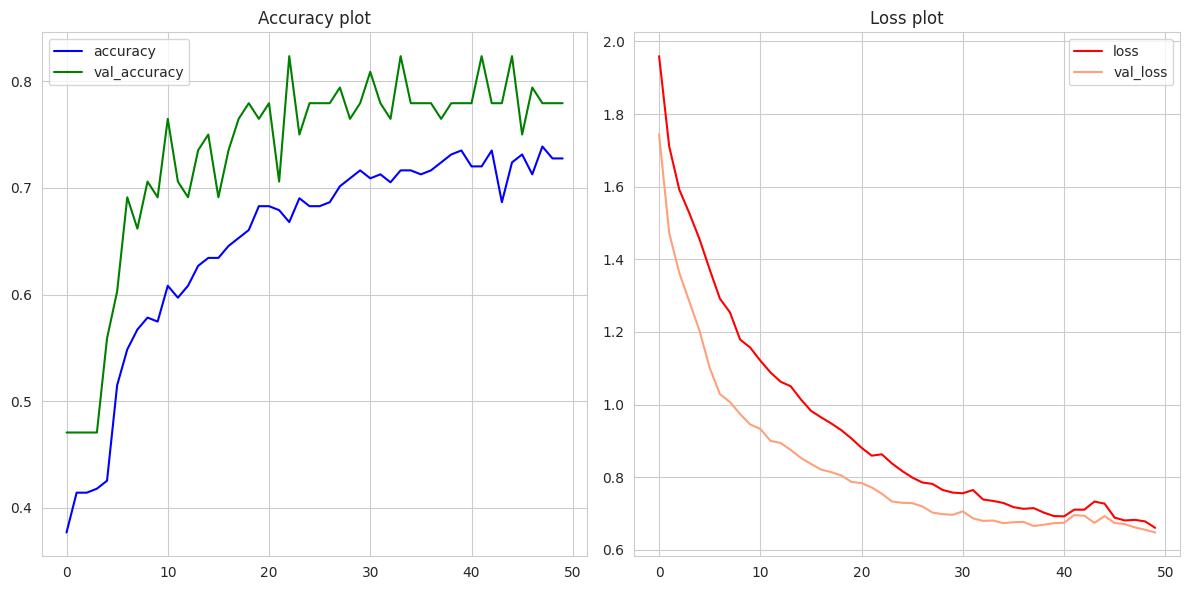

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
ax[0].plot(range(epochs), r_2.history['accuracy'], color='blue', label = 'accuracy')
ax[0].plot(range(epochs), r_2.history['val_accuracy'], color='green', label = 'val_accuracy')
ax[0].set_title('Accuracy plot')
ax[0].legend()
ax[1].plot(range(epochs), r_2.history['loss'], color='red', label = 'loss')
ax[1].plot(range(epochs), r_2.history['val_loss'], color = 'lightsalmon', label = 'val_loss')
ax[1].set_title('Loss plot')
ax[1].legend()
fig.tight_layout()
fig.show()

Worse accuracy on test set - accuracy on test set decreases by 10% but loss function looks better

deleting a correlating columns doesn't increase model preds

**Deleting outliers in respect of boxplots.** Columns with eliminated outliers will be gvh and aac. Columns lip and chg won't be taken into account because of their small range of values

In [ ]:
Q1 = data[['gvh','aac']].quantile(0.25)
Q3 = data[['gvh','aac']].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((data[['gvh','aac']] < Q1 - 1.5 * IQR) | (data[['gvh','aac']] > Q3 + 1.5 * IQR))
data_filtered = data[~outlier_condition.any(axis = 1)]


In [ ]:
X = data_filtered.iloc[:,:-1]
Y = data_filtered.iloc[:,-1]

Y = Y.to_numpy()
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = Y.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)

In [ ]:
x_train.shape

(252, 7)

In [ ]:
epochs = 50
best_model = tuner.get_best_models(num_models = 1)[0]
r_3 = best_model.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/50
8/8 [==============================] - 4s 120ms/step - loss: 0.7407 - accuracy: 0.7817 - val_loss: 0.8117 - val_accuracy: 0.7812
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.6882 - accuracy: 0.7579 - val_loss: 0.7490 - val_accuracy: 0.8125
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6524 - accuracy: 0.7937 - val_loss: 0.7600 - val_accuracy: 0.8281
Epoch 4/50
8/8 [==============================] - 0s 33ms/step - loss: 0.6226 - accuracy: 0.7976 - val_loss: 0.7086 - val_accuracy: 0.8125
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6007 - accuracy: 0.8056 - val_loss: 0.7047 - val_accuracy: 0.8125
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5884 - accuracy: 0.8095 - val_loss: 0.6988 - val_accuracy: 0.8281
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5717 - accuracy: 0.8254 - val_loss: 0.6742 - val_accuracy: 0.7656
Epoch 8/50
8/8 [==========

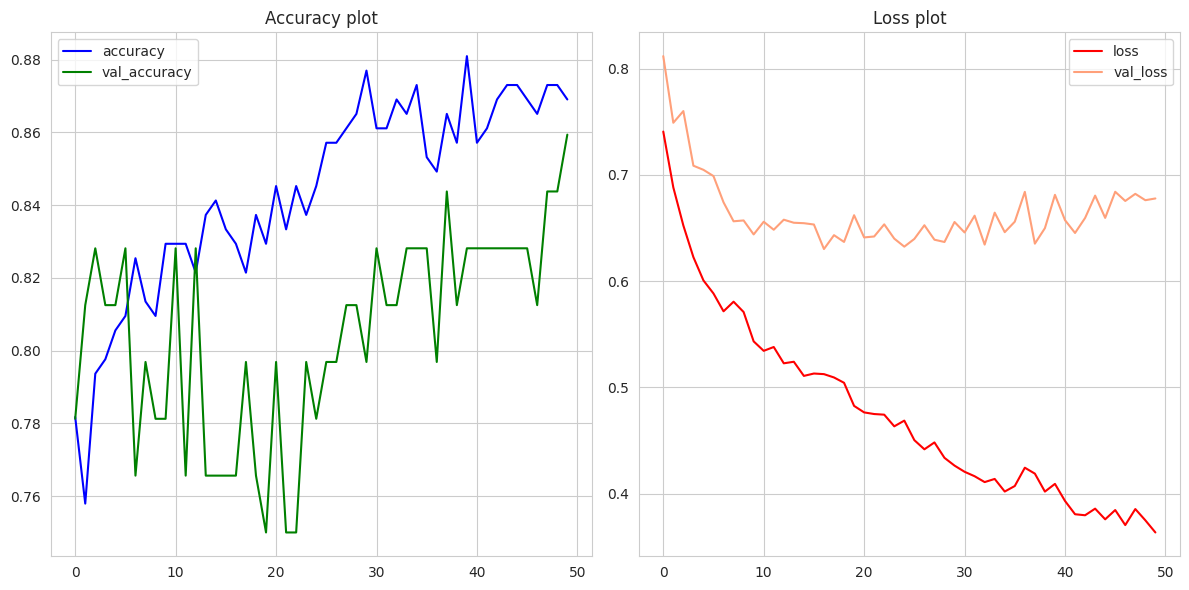

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
ax[0].plot(range(epochs), r_3.history['accuracy'], color='blue', label = 'accuracy')
ax[0].plot(range(epochs), r_3.history['val_accuracy'], color='green', label = 'val_accuracy')
ax[0].set_title('Accuracy plot')
ax[0].legend()
ax[1].plot(range(epochs), r_3.history['loss'], color='red', label = 'loss')
ax[1].plot(range(epochs), r_3.history['val_loss'], color = 'lightsalmon', label = 'val_loss')
ax[1].set_title('Loss plot')
ax[1].legend()
fig.tight_layout()
fig.show()

Deleting outliers make the val_accuracy plot more unstable, the loss plot of val_loss doesn't change.